# Application of LTSM Model
Explore the application of a trained LSTM model to form trading strategy  
Using RSI strategy as a benchamrk, to measure the performance of the LSTM model

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow.keras.models import load_model
 

Load the model and data

In [2]:
model = load_model('lstm.h5')
df = pd.read_csv('fb_rsi.csv')
df['date'] = pd.to_datetime(df['date'])

Convert dates and closing prices to numpy array

In [3]:
close = np.array(df['close'])
date = np.array(df['date'])

Split the data into test data for forecasting

In [4]:
split = 100000
date_val = date[split:]
x_val = close[split:]

window_size = 5

Function for forecasting of test data
Similar to training, forecasting uses windows of 5 timesteps to forecast forward timestep

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(250).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Forecasting testing data

In [6]:
forecast = model_forecast(model, close[..., np.newaxis], window_size)
forecast = forecast[split - window_size:-1, -1, 0]

Visualizing forecasted time series

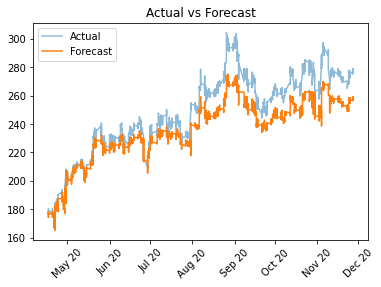

In [7]:
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b %y')

plt.plot(date_val, x_val, alpha=0.5)
plt.plot(date_val, forecast)

x = plt.gca()
x.xaxis.set_major_locator(locator)
x.xaxis.set_major_formatter(fmt)
plt.xticks(rotation=45)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.show()

MAE of the model is 11.9 is decent but can be improved with tuning and longer training time

In [8]:
mae = tf.keras.metrics.mean_absolute_error(x_val, forecast).numpy()
print(f'Mean absolute error of the model: {mae}')

Mean absolute error of the model: 11.902925491333008


New dataframe for testing data

In [9]:
ndf = df.iloc[split:]

Variables for strategy

In [10]:
ndf['forecast'] = np.float64(forecast)
pred = ndf['forecast']
pred_pc = pred.pct_change()
rsi = ndf['rsi']
close = ndf['close']

# Strategy using LSTM model
The model was not able to forecast the exact magnitude of the closing prices, but was able to forecast the direction the prices were moving towards  
Strategy uses the forecasted direction of the prices movement to exit a trade   

Entering small dip in closing prices(long strategy)
* Enter if current closing price is lower than previous 3 periods
* Exit if current closing price is higher than previous 2 periods and forecasted price is more than previous period

Short strategy is the opposite conditions, entering when there a small raise and exiting when prices come downn

In [11]:
#Conditions for long strategy
cond1 = (close < close.shift(1)) & (close < close.shift(2)) & (close < close.shift(3)) #Condition for entering trade
cond2 = (close > close.shift(1)) & (close > close.shift(2)) & (pred > pred.shift(-1)) #Condition for exiting trade

#Conditions for short strategy
cond3 = (close > close.shift(1)) & (close > close.shift(2)) & (close > close.shift(3)) #Condition for entering trade 
cond4 = (close < close.shift(1)) & (close < close.shift(2)) & (pred < pred.shift(-1)) #Condition for exiting trade

#Applying the vectorized conditions, speed up operation compared to looping through 
ml_enterlong = close[cond1]
ml_exitlong = close[cond2]

ml_entershort = close[cond3]
ml_exitshort = close[cond4]

Store trading signals into dataframe

In [12]:
ndf['ml_long'] = ml_enterlong
ndf['ml_exit_long'] = ml_exitlong

ndf['ml_short'] = ml_entershort
ndf['ml_exit_short'] = ml_exitshort

Backtesting strategy, calculating profits and losses

In [13]:
ndf['ml_exit_long'].fillna(method='bfill', inplace=True)
ml_long_pnl = ndf['ml_exit_long'].shift(-1) - ndf['ml_long']
ndf['ml_long_pnl'] = ml_long_pnl

ndf['ml_exit_short'].fillna(method='bfill', inplace=True)
ml_short_pnl = ndf['ml_short'] - ndf['ml_exit_short'].shift(-1)
ndf['ml_short_pnl'] = ml_short_pnl

ndf['ml_total_pnl'] = ndf[['ml_short_pnl', 'ml_long_pnl']].sum(axis=1)

LSTM strategy generated 3 times the amount of trade compared RSI strategy
Strategy made 35,519 trades in 8 months

In [14]:
print(f"Total number of trades from LSTM long strategy: {ndf['ml_long_pnl'].count()}")
print(f"Total number of trades from LSTM short strategy: {ndf['ml_short_pnl'].count()}\n")

print(f"Total number of trades from RSI long strategy: {ndf['long_pnl'].count()}")
print(f"Total number of trades from RSI short strategy: {ndf['short_pnl'].count()}")

Total number of trades from LSTM long strategy: 17324
Total number of trades from LSTM short strategy: 18195

Total number of trades from RSI long strategy: 5993
Total number of trades from RSI short strategy: 6045


# Visualizing LSTM strategy's performance
Comparing holding stock with RSI strategy and LSTM strategy
* Note that slippage and trading cost are not accounted for these strategies

Profit from RSI strategies: 412.8200000000005
Max long RSI draw down: -6.585000000000037
Max short RSI draw down: -60.439999999999856
Max total draw down: 0.0

Profit from LSTM short strategy: 190.41500000000175
Profit from LSTM long strategy: 760.7499999999995
Profit from both LSTM strategies: 951.1650000000012
Max long draw down: -25.624999999999687
Max short draw down: -6.955000000000325
Max total draw down: -22.999999999999915


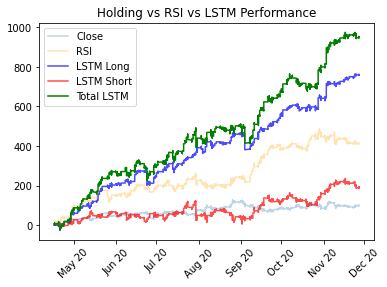

In [15]:
performance_long = ndf['long_pnl'].cumsum().fillna(method='ffill')
performance_short = ndf['short_pnl'].cumsum().fillna(method='ffill')
total_performance = ndf['total_pnl'].cumsum().fillna(method='ffill')

ml_performance_long = ndf['ml_long_pnl'].cumsum().fillna(method='ffill')
ml_performance_short = ndf['ml_short_pnl'].cumsum().fillna(method='ffill')
ml_total_performance = ndf['ml_total_pnl'].cumsum().fillna(method='ffill')

print(f"Profit from RSI strategies: {(ndf['total_pnl'].sum())}")
print(f"Max long RSI draw down: {performance_long.min()}")
print(f"Max short RSI draw down: {performance_short.min()}")
print(f"Max total draw down: {total_performance.min()}\n")

print(f"Profit from LSTM short strategy: {(ndf['ml_short_pnl'].sum())}")
print(f"Profit from LSTM long strategy: {ndf['ml_long_pnl'].sum()}")
print(f"Profit from both LSTM strategies: {(ndf['ml_total_pnl'].sum())}")
print(f"Max long draw down: {ml_performance_long.min()}")
print(f"Max short draw down: {ml_performance_short.min()}")
print(f"Max total draw down: {ml_total_performance.min()}")

locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b %y')

plt.plot(ndf['date'], ndf['close'] - ndf['close'][100000], alpha=0.3) #Performance of holding stock in the same time period
plt.plot(ndf['date'], total_performance, alpha=0.3, color='orange')
plt.plot(ndf['date'], ml_performance_long, alpha=0.7, color='blue')
plt.plot(ndf['date'], ml_performance_short, alpha=0.7, color='red')
plt.plot(ndf['date'], ml_total_performance, color='green')
x = plt.gca()
x.xaxis.set_major_locator(locator)
x.xaxis.set_major_formatter(fmt)
plt.xticks(rotation=45)
plt.title('Holding vs RSI vs LSTM Performance')
plt.legend(['Close', 'RSI', 'LSTM Long', 'LSTM Short', 'Total LSTM'])
plt.show()

# Conclusion
LSTM strategy outperformed RSI strategy by more than twice, with lesser draw down between the long and short stategies  
LSTM strategy incurred some losing streaks, needs a stop-loss feature to minimize losses 

## Strategy's limiation:
* Strategy only buys or sells 1 stock during each trade, strategy could be scaled up based on account size

## To-do list:
* Train and test models on more stocks to determine signal generating effectiveness
* Add risk management feature, kelly criterion to allocate bet size
* Add stop-loss feature, limit amount on losing trades